In [4]:
!pip install japanize-matplotlib
import japanize_matplotlib

分岐点（base != rollout）: 93
[t=01] 一、午后（ごご）の授業 | 手を上げかけて引っ込める（自信の揺れ）
  base=connect  rollout=give    | x_base=[0.5  0.55]  x_roll=[0.5  0.55]
[t=02] 一、午后（ごご）の授業 | 疲労と欠乏で『わからない』感覚が増す
  base=freeze   rollout=connect | x_base=[0.56 0.59]  x_roll=[0.59 0.6 ]
[t=03] 一、午后（ごご）の授業 | 先生に見つかり指名される（公的圧力）
  base=freeze   rollout=connect | x_base=[0.48 0.68]  x_roll=[0.6  0.59]
[t=04] 一、午后（ごご）の授業 | 立つが答えられない（無力感の顕在化）
  base=freeze   rollout=give    | x_base=[0.4  0.74]  x_roll=[0.61 0.55]
[t=05] 一、午后（ごご）の授業 | 嘲笑と赤面（自己防衛への退避）
  base=defend   rollout=give    | x_base=[0.22 0.86]  x_roll=[0.55 0.58]
[t=06] 一、午后（ごご）の授業 | 涙と関係の再解釈（推測による共感の芽）
  base=defend   rollout=give    | x_base=[0.49 0.87]  x_roll=[0.99 0.48]
[t=07] 二、活版所 | 友人たちの輪から外れて立ち去る
  base=defend   rollout=reframe | x_base=[0.26 0.78]  x_roll=[0.93 0.28]
[t=08] 二、活版所 | 町の祝祭準備を横目に働きへ向かう
  base=defend   rollout=connect | x_base=[0.18 0.89]  x_roll=[0.98 0.31]
[t=09] 二、活版所 | 作業を受け取り黙々と拾い始める
  base=defend   rollout=freeze  | x_base=[0.2 0.9]  x_roll

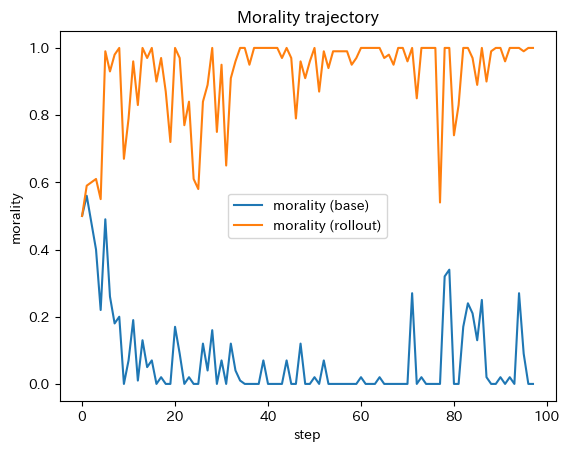

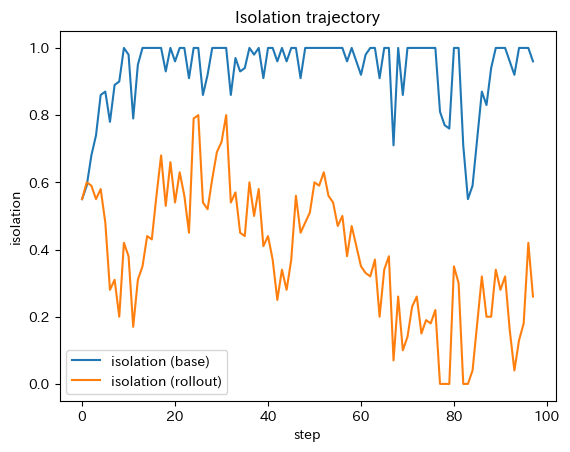

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

JSON_PATH = "/content/sample_g_1_reconstructed_keep_last9.json"  # ここをあなたのパスに

# =========
# 0) JSONロード（あなたの形式：time_series_dataにglobal_step, event, x, status 等）
# =========
def load_points(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        chapters = json.load(f)

    pts = []
    for ch in chapters:
        scene = ch["chapter"]["title"]
        for p in ch["time_series_data"]:
            pts.append({
                "t": int(p["global_step"]),
                "scene": scene,
                "event": p["event"],
                "x": np.array(p["x"], dtype=float),  # [morality, isolation, time]
                "status": p.get("status", "unlabeled"),
                "label": p.get("label", None),
                "desc": p.get("desc", ""),
            })
    pts.sort(key=lambda d: d["t"])
    return pts

pts = load_points(JSON_PATH)
T = len(pts)
assert T >= 2, "点が少なすぎます"

# base dynamics: 物語が持つ“外的変化”を差分として抽出
base_dx = []
for i in range(T-1):
    base_dx.append(pts[i+1]["x"][:2] - pts[i]["x"][:2])  # morality, isolation のみ
base_dx.append(np.zeros(2, dtype=float))  # 終端

# =========
# 1) 「同じ孤独でも」どう反応するか：行動（自己防衛 vs 共感）
# =========
ACTIONS = ["defend", "freeze", "reframe", "connect", "give"]
# 行動が内面に与える“追加差分”（ここがあなたの思想を入れる場所）
ACTION_DX = {
    "defend": np.array([-0.08, +0.06]),   # 自己防衛：道徳↓ 孤立↑
    "freeze": np.array([-0.03, +0.04]),   # 固まる：微悪化
    "reframe":np.array([+0.05, -0.02]),   # 認知の組み替え：道徳↑ 孤立微減
    "connect":np.array([+0.06, -0.06]),   # つながる：道徳↑ 孤立↓
    "give":   np.array([+0.09, -0.05]),   # 与える：道徳↑↑ 孤立↓
}

def clip01(x):
    return np.minimum(1.0, np.maximum(0.0, x))

# =========
# 2) 報酬設計：慈悲・共感へ“逆算”して寄せる
# =========
# MDPの「即時報酬 r(x,a)」の作り方（MDPの定義に沿う）:contentReference[oaicite:5]{index=5}
def reward(x, a, t, event_text=""):
    """
    x: [morality, isolation]
    """
    m, iso = x
    # 基本：道徳↑がプラス、孤立↑がマイナス
    r = +2.0*m - 1.6*iso

    # “自己防衛の癖”に小さな罰（ただしゼロにはしない：現実味のため）
    if a in ("defend", "freeze"):
        r -= 0.25

    # 出会い（例：カムパネルラ等）っぽいイベントでは「つながる/与える」を少し後押し
    if any(k in event_text for k in ["カムパネルラ", "友", "一緒", "手", "助"]):
        if a in ("connect", "give"):
            r += 0.35

    return r

def terminal_bonus(xT):
    # 終盤で「慈悲・共感」側に寄っているほど大きいボーナス
    m, iso = xT
    return 8.0*m - 6.0*iso

# =========
# 3) 環境ステップ：物語の外的変化 + 行動の内的変化
# =========
def step(x, a, t):
    # 物語の外的変化（次の出来事が来る“流れ”）
    dx_world = base_dx[t]
    # 内的選択（同じ孤独でもどう反応するか）
    dx_act = ACTION_DX[a]
    x_next = clip01(x + dx_world + dx_act)
    return x_next

# =========
# 4) ベース方策（何もしないと自己防衛に寄る、をモデル化）
# =========
def base_policy(x, t, event_text=""):
    m, iso = x
    if iso >= 0.78:
        return "defend"     # 孤立が高いと刺さる自己防衛
    if m >= 0.70 and iso >= 0.60:
        return "reframe"
    if "助" in event_text or "手" in event_text:
        return "connect"
    return "freeze"

# =========
# 5) 逆算ロールアウト（1手先を変えて、未来の合計を最大化）
# 有限ホライズン＆（ほぼ）決定論はロールアウトに向く :contentReference[oaicite:6]{index=6}
# =========
def rollout_action(x, t):
    best_a = None
    best_return = -1e18
    for a0 in ACTIONS:
        x_sim = x.copy()
        G = 0.0
        # まず候補行動
        x_sim = step(x_sim, a0, t)
        G += reward(x_sim, a0, t, pts[t]["event"])
        # 以降はベース方策で最後まで“予測”
        for tt in range(t+1, T-1):
            ev = pts[tt]["event"]
            a = base_policy(x_sim, tt, ev)
            x_sim = step(x_sim, a, tt)
            G += reward(x_sim, a, tt, ev)
        G += terminal_bonus(x_sim)
        if G > best_return:
            best_return = G
            best_a = a0
    return best_a, best_return

def simulate(policy="base"):
    x = pts[0]["x"][:2].copy()
    xs = [x.copy()]
    acts = []
    for t in range(T-1):
        ev = pts[t]["event"]
        if policy == "base":
            a = base_policy(x, t, ev)
        elif policy == "rollout":
            a, _ = rollout_action(x, t)
        else:
            raise ValueError("policy must be 'base' or 'rollout'")
        x = step(x, a, t)
        acts.append(a)
        xs.append(x.copy())
    return np.array(xs), acts

xs_base, acts_base = simulate("base")
xs_roll, acts_roll = simulate("rollout")

# =========
# 6) 「同じ孤独でも」分岐した“出会い／成長ポイント”を抽出
# =========
pivots = []
for t in range(T-1):
    if acts_base[t] != acts_roll[t]:
        pivots.append((t, pts[t]["scene"], pts[t]["event"], acts_base[t], acts_roll[t], xs_base[t], xs_roll[t]))

print("分岐点（base != rollout）:", len(pivots))
for t, scene, ev, ab, ar, xb, xr in pivots[:12]:
    print(f"[t={pts[t]['t']:02d}] {scene} | {ev}")
    print(f"  base={ab:7s}  rollout={ar:7s} | x_base={xb.round(3)}  x_roll={xr.round(3)}")

# =========
# 7) 可視化（成長：morality↑ / 孤独：isolation↓）
# =========
ts = [p["t"] for p in pts] + [pts[-1]["t"]+1]
plt.figure()
plt.plot(xs_base[:,0], label="morality (base)")
plt.plot(xs_roll[:,0], label="morality (rollout)")
plt.legend(); plt.title("Morality trajectory"); plt.xlabel("step"); plt.ylabel("morality"); plt.show()

plt.figure()
plt.plot(xs_base[:,1], label="isolation (base)")
plt.plot(xs_roll[:,1], label="isolation (rollout)")
plt.legend(); plt.title("Isolation trajectory"); plt.xlabel("step"); plt.ylabel("isolation"); plt.show()
